In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torchvision import transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


In [5]:
batch_size = 16
image_size = 64

# Create the dataset
anime_faces_dataset = dset.ImageFolder(
    root="/content/drive/MyDrive/anime_classification/",
    transform=transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]))

In [6]:
classes = anime_faces_dataset.classes

classes

['Real_images', 'bad_fake_images']

In [7]:
dataset_size = len(anime_faces_dataset)
train_size = int(dataset_size * 0.8)
test_size = dataset_size - train_size

print(f"Dataset size: {dataset_size}")
print(f"Train size: {train_size}")
print(f"Test size: {test_size}")

Dataset size: 2039
Train size: 1631
Test size: 408


In [8]:
train_set, test_set = torch.utils.data.random_split(anime_faces_dataset, [train_size, test_size])

In [9]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

In [10]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

images.shape

# Batch size, Number of channels, Height, Width

torch.Size([16, 3, 64, 64])

Real_images Real_images bad_fake_images bad_fake_images bad_fake_images Real_images bad_fake_images bad_fake_images


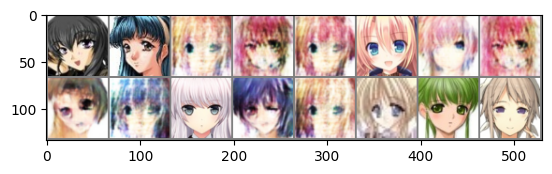

bad_fake_images bad_fake_images Real_images bad_fake_images bad_fake_images Real_images Real_images Real_images


In [11]:
# PyTorch tensors use (C, H, W) order (channels first).

# Matplotlib expects (H, W, C) order (channels last).

def display(img):
  img = img / 2 + 0.5
  img = img.permute(1, 2, 0)
  npimg = img.numpy()

  plt.imshow(npimg)
  plt.xticks()
  plt.yticks()
  plt.show()

print(" ".join(f'{classes[labels[j]]:5s}' for j in range(8)))

display(make_grid(images, 8))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8, 16)))

<h2>Building the Descriminator </h2>

In [17]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of feature maps in descriminator
ndf = 64

# Learning rate for optimizers
lr = 0.0002

In [13]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)

  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [20]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.net = nn.Sequential(
        # input is ''(nc) * 64 * 64
        nn.Conv2d(
            in_channels = nc,
            out_channels = ndf,
            kernel_size = 4,
            stride = 2,
            padding = 1,
            bias = False
        ),
        nn.LeakyReLU(0.2, inplace = True),

        # state size. (ndf) * 32 * 32
        nn.Conv2d(
            in_channels = ndf,
            out_channels = ndf * 2,
            kernel_size = 4,
            stride = 2,
            padding = 1,
            bias = False
        ),
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, inplace = True),

        # state size (ndf*2) * 16 * 16
        nn.Conv2d(
            in_channels = ndf * 2,
            out_channels = ndf * 4,
            kernel_size = 4,
            stride = 2,
            padding = 1,
            bias = False
        ),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace = True),

        # state size (ndf*4) * 8 * 8
        nn.Conv2d(
            in_channels = ndf * 4,
            out_channels = ndf * 8,
            kernel_size = 4,
            stride = 2,
            padding = 1,
            bias = False
        ),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace = True),

        # state size (ndf*8) * 4 * 4
        nn.Conv2d(
            in_channels = ndf * 8,
            out_channels = 1,
            kernel_size = 4,
            stride = 1,
            padding = 0,
            bias = False
        ),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.net(x)

In [21]:
netD = Discriminator().to(device)
netD.apply(weights_init)

print(netD)

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [22]:
criterion = nn.BCELoss()
optimizer = optim.Adam(netD.parameters(), lr = lr, betas = (0.5, 0.999))

In [23]:
for epoch in range(2):
  running_loss = 0.0

  for i, data in enumerate(train_loader, 0):
    # get the inputs; data us a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = netD(inputs)

    loss = criterion(outputs.flatten(), labels.float())
    loss.backward()

    optimizer.step()

    running_loss += loss.item()

    if i % 20 == 0: # print every 20 mini batches
      print(f'Epoch: [{epoch + 1}, Step: {i + 1:5d}] loss: {running_loss / 20:.3f}')
      running_loss = 0.0

print("Finished Training")

Epoch: [1, Step:     1] loss: 0.047
Epoch: [1, Step:    21] loss: 0.130
Epoch: [1, Step:    41] loss: 0.006
Epoch: [1, Step:    61] loss: 0.002
Epoch: [1, Step:    81] loss: 0.001
Epoch: [1, Step:   101] loss: 0.003
Epoch: [2, Step:     1] loss: 0.000
Epoch: [2, Step:    21] loss: 0.000
Epoch: [2, Step:    41] loss: 0.000
Epoch: [2, Step:    61] loss: 0.000
Epoch: [2, Step:    81] loss: 0.000
Epoch: [2, Step:   101] loss: 0.000
Finished Training


Ground truth: 
Real_images Real_images Real_images bad_fake_images Real_images Real_images bad_fake_images bad_fake_images


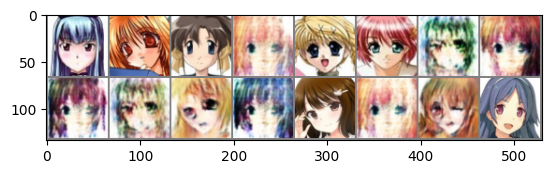

bad_fake_images bad_fake_images bad_fake_images bad_fake_images Real_images bad_fake_images bad_fake_images Real_images


In [24]:
dataiter = iter(test_loader)

images, labels = next(dataiter)

print("Ground truth: ")

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))
display(make_grid(images, 8))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8, 16)))

In [25]:
outputs = netD(images.to(device))

Predicetd: 
Real_images Real_images Real_images bad_fake_images Real_images Real_images bad_fake_images bad_fake_images


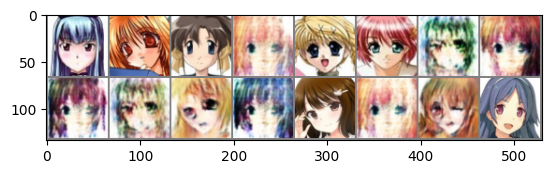

bad_fake_images bad_fake_images bad_fake_images bad_fake_images Real_images bad_fake_images bad_fake_images Real_images


In [26]:
predicetd = torch.round(outputs.flatten())

print("Predicetd: ")

print(' '.join(f'{classes[predicetd.long()[j]]:5s}' for j in range(8)))
display(make_grid(images, 8))
print(' '.join(f'{classes[predicetd.long()[j]]:5s}' for j in range(8, 16)))

In [27]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    # calculate outputs by running images through the network
    outputs = netD(images)

    predicted = torch.round(outputs.flatten()).long()

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {test_size} test images: {100 * correct // total} %')


Accuracy of the network on the 408 test images: 100 %
